In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal, optimize
from tqdm import tqdm
import h5py
import pandas as pd

import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.analysis import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

# Global parameters

In [2]:
# global parameters
dt=1
epsilon=0.2
sigma=0.01
N=int(1e4)
mu=0.2

In [3]:
#mean field solution for T->inf
def a_inf(lam, mu, h):
    return mu*(1-np.exp(-h*dt))/(1-lam*(1-mu)-lam*mu*np.exp(-h*dt))

lam=0.0
print(lam, mu, a_inf(lam, mu, 0), a_inf(lam, mu, 1e3))

0.0 0.2 0.0 0.2


# Implementation of measures

### 1. Find smallest $h$ for which the overlap with the zero-input case is less than discrimination error $\varepsilon$
Note: $a(0)=0$ for all $\lambda$ and $\mu$ such that $P(o)=\mathcal{N}(0,\sigma)$

In [58]:
# def calc_overlap(pmf1, pmf2):
#     """
#     calculates the overlap between two discrete probability mass functions
#     ATTENTION: needs user to ensure that domains are identical!
#     """
#     assert len(pmf1) == len(pmf2)
#     return np.sum(np.minimum(pmf1, pmf2)) * 0.5


# def find_discriminable_inputs(pmf, h_range, pmf_refs, epsilon:float, start="left", verbose=False):
#     """
#     Determine all inputs h in range h_range such that the overlap between all pmfs is less than epsilon
#     The pmfs of h_range[0] and h_range[1] sever as boundaries

#     # Parameter
#     - pmf: function
#     - h_range: array-like with length two
#     - epsilon: float
#         discrimination error that specifies maximal overlap between two probability mass functions
#     """
#     assert len(h_range) == 2
#     h_left, h_right = h_range
#     assert len(pmf_refs) == 2
#     pmf_ref_left, pmf_ref_right = pmf_refs
    
#     # make sure that boundaries of h_range overlap with the reference pmfs
#     pmf_left = pmf(h_left)
#     overlap_left = calc_overlap(pmf_ref_left, pmf_left)
#     assert overlap_left > epsilon
#     pmf_right = pmf(h_right)
#     overlap_right = calc_overlap(pmf_ref_right, pmf_right)
#     assert overlap_right > epsilon
    
#     # pmf_ref declares the pmf to which the overlap is calculated; at beginning this deviates from pmf_cur
#     # pmf_end declares pmf that constraints the search for h
#     if start == "left": 
#         pmf_ref = pmf_ref_left
#         pmf_end = pmf_ref_right
#         h_cur = h_left
#         pmf_cur = pmf_left
#         overlap_beg = overlap_left
#     if start == "right":
#         pmf_ref = pmf_ref_right
#         pmf_end = pmf_ref_left
#         h_cur = h_right
#         pmf_cur = pmf_right
#         overlap_beg = overlap_right

#     overlap_end = calc_overlap(pmf_end, pmf_cur)

#     assert overlap_beg > epsilon
#     assert overlap_end < epsilon

#     hs = []
#     # loop until ovelap between pmf_cur and pmf_end is smaller than epsilon
#     while overlap_end < epsilon:
#         def func(h):
#             return calc_overlap(pmf_ref, pmf(h)) - epsilon

#         if start == "left":
#             h_cur = optimize.bisect(func, h_cur, h_right)
#         elif start=="right":
#             h_cur = optimize.bisect(func, h_left, h_cur)
#         pmf_cur = pmf(h_cur)
#         overlap_end = calc_overlap(pmf_end, pmf_cur)
#         if verbose:
#             print("possible solution: ",h_cur, overlap_end, end=" ... ")
#         # if new overlap is smaller than epsilon, add h_cur to list and take current pmf as new reference
#         if overlap_end < epsilon:
#             hs.append(h_cur)
#             pmf_ref = pmf_cur
#             print("accepted")
#         else:
#             print("rejected")
#     return hs


# def dynamic_range(h_range):
#     """
#     Calculate the dynamic range from the range h_range
#     """
#     assert len(h_range) == 2
#     h_left, h_right = h_range
#     return 10 * (np.log10(h_right) - np.log10(h_left))

[0.08791606053470957, 0.18431236719523952, 0.29100251598853466, 0.4104503188933367, 0.5461252499403776, 0.7031418123652079, 0.8894902142984816, 1.1187026753957172, 1.4165832197970933, 1.8427656613551464]
[2.475008763296316, 1.7818644298757167, 1.3763986698980624, 1.088715806871806, 0.865573098429537, 0.6832514514483375, 0.5291001765680747, 0.3955692722790745, 0.2777862803291233, 0.1724252431424893]


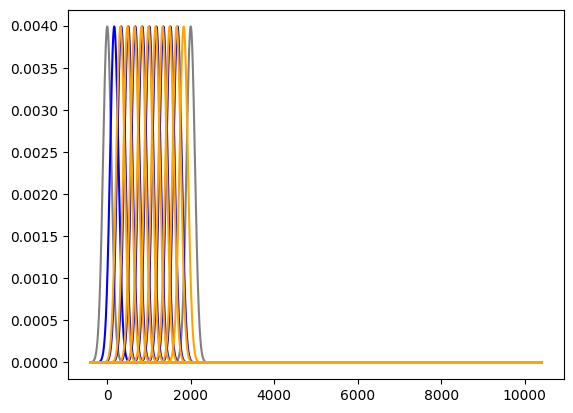

In [97]:
# test discriminable intervals
lam = 0.0
Xs = np.arange(-4*sigma*N,N+4*sigma*N)

def pmf(h):
    # see below for formal derivation, here just as a test
    A = mu*(1-np.exp(-h*dt))/(1-lam*(1-mu)-lam*mu*np.exp(-h*dt)) * N
    # in domain with delta = 1
    delta = 1
    return stats.norm.pdf(Xs, A, sigma*N)*delta

h_range=[0,1e3]
pmf_ref_left = pmf(h_range[0])
pmf_ref_right = pmf(h_range[1])

plt.plot(Xs,pmf_ref_left, color="gray")
plt.plot(Xs,pmf_ref_right, color="gray")

hs_left = find_discriminable_inputs(pmf, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="left")
print(hs_left)
for h in hs_left:
    plt.plot(Xs,pmf(h), color="blue")

hs_right = find_discriminable_inputs(pmf,h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right")
print(hs_right)
for h in hs_right:
    plt.plot(Xs,pmf(h), color="orange")
#plt.legend()

# Consider network output with Gaussian noise
The output of the network is the sum of the network activity and Gaussian noise $\eta\sim\mathcal{N}(0,1)$ such that 
$$ o = a + \sigma\eta $$
The output is thus a convolution between $P(a)$ and $\mathcal{N}(0,\sigma)$.

For $T\to\infty$ the distribution of activity is a delta-distribution such that the the output distribution becomes a shifted Gaussian
$$ P(o) = \mathcal{N}(a(h|\lambda,\mu), \sigma)$$

# Analytic solution for $T\to\infty$
For the $T\to\infty$ case, we have a one-to-one mapping between input $h$ and network activity $a$, given by 
$$a(h|\lambda, \mu) = \frac{\mu\left(1-e^{-h\Delta t}\right)}{1-\lambda(1-\mu)-\lambda\mu e^{-h\Delta t}}$$

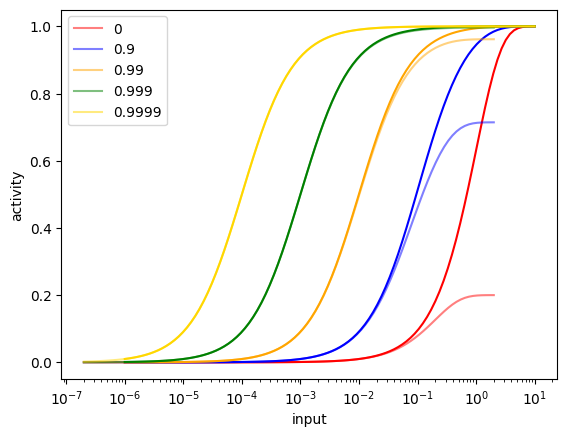

In [35]:
hs=np.logspace(-6,1,100)
colors=['red','blue','orange','green', 'gold']
for i,lam in enumerate([0,0.9,0.99,0.999, 0.9999]):
    plt.plot(hs*0.2, a_inf(lam, mu, hs), label='{}'.format(lam), color=colors[i], alpha=0.5)
    plt.plot(hs, a_inf(lam, 1.0, hs), color=colors[i])
plt.xscale("log")
plt.xlabel("input")
plt.ylabel("activity")
plt.legend()

100%|██████████| 30/30 [00:26<00:00,  1.12it/s]


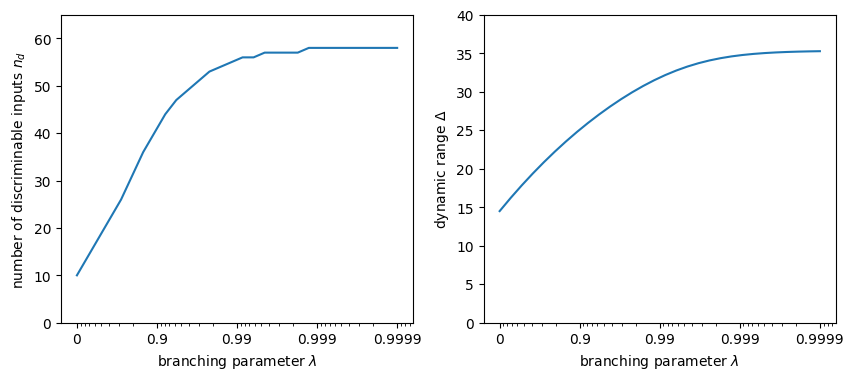

In [100]:
# network parameters
Xs = np.arange(-4 * sigma * N, N + 4 * sigma * N)
lams_inf = 1 - np.logspace(-4, 0, 30)

# analysis parameters
drs_inf = np.zeros(len(lams_inf))
nds_inf = np.zeros(len(lams_inf))
h_range = [0, 1e3]
# attempt to match previous data analysis
logh = np.arange(-7, 1.5, 0.05)  # 170 elements

for i, lam in tqdm(enumerate(lams_mf), total=len(lams_mf)):
    # distribution of noisy output
    def pmf_o_given_h(h):
        A = a(h, lam, mu) * N
        return stats.norm.pdf(Xs, A, sigma * N)

    pmf_ref_left = pmf_o_given_h(h_range[0])
    pmf_ref_right = pmf_o_given_h(h_range[1])
    hs_left = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon)
    hs_right = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right")
    drs_inf[i] = dynamic_range((hs_left[0], hs_right[0]))
    nds_inf[i] = 0.5 * (len(hs_left) + len(hs_right))

# plot the number of discriminable inputs for different values of epsilon and T in a main plot with an inset
markers = ["o", "s", "^", "P", "d"]
legends = ["$1$ ms", "$10$ ms", "$10^2$ ms", "$10^3$ ms", "$10^4$ ms"]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(1 - lams_inf, nds_inf)
ax[0].set_xlabel("branching parameter $\lambda$")
ax[0].set_ylim(0, 65)
ax[0].set_ylabel("number of discriminable inputs $n_d$")
ax[0].set_xscale("log")
ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[0].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[0].invert_xaxis()
ax[1].plot(1 - lams_inf, drs_inf)
ax[1].set_xlabel("branching parameter $\lambda$")
ax[1].set_ylim(0, 40)
ax[1].set_ylabel("dynamic range $\Delta$")
ax[1].set_xscale("log")
ax[1].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[1].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[1].invert_xaxis()

# Analysis of data

In [12]:
beta_approximation = "./dat/beta_approximation_simulation.h5"

# show content of file with visit function
# with h5py.File(beta_approximation, "r") as f:
#     f.visit(print)

# create empty pandas dataframe with colums [window, lam, h, seed, a, b, loc, scale]
df = pd.DataFrame(columns=["window", "lam", "h", "seed", "a", "b", "loc", "scale"])
# iterate over all groups in file and add to dataframe
with h5py.File(beta_approximation, "r") as f:
    for window in f.keys():
        for lam in f[window].keys():
            for h in f[window][lam].keys():
                for seed in f[window][lam][h].keys():
                    fit = np.array(f[window][lam][h][seed])
                    a = fit[0]
                    b = fit[1]
                    loc = fit[2]
                    scale = fit[3]
                    df.loc[len(df)] = {
                        "window": float(window),
                        "lam": float(lam),
                        "h": float(h),
                        "seed": int(seed),
                        "a": a,
                        "b": b,
                        "loc": loc,
                        "scale": scale  
                    }
print(df)

        window     lam         h  seed            a              b     loc  \
0     1.000000  0.0000  0.000100  1000    14.808305  123437.909027 -0.0001   
1     1.000000  0.0000  0.000126  1000    13.215659  105610.988024 -0.0001   
2     1.000000  0.0000  0.000158  1000    11.874985   90205.258274 -0.0001   
3     1.000000  0.0000  0.000200  1000    10.764795   76984.736030 -0.0001   
4     1.000000  0.0000  0.000251  1000     9.894010   65869.123281 -0.0001   
...        ...     ...       ...   ...          ...            ...     ...   
5197  0.000001  0.9999  3.162278  1000  4513.446087       2.356494 -0.0001   
5198  0.000001  0.9999  3.981072  1000  4646.903952       2.367591 -0.0001   
5199  0.000001  0.9999  5.011872  1000  4715.214832       2.373272 -0.0001   
5200  0.000001  0.9999  6.309573  1000  4743.555743       2.375827 -0.0001   
5201  0.000001  0.9999  7.943282  1000  4751.837193       2.376472 -0.0001   

       scale  
0     1.0002  
1     1.0002  
2     1.0002  
3  

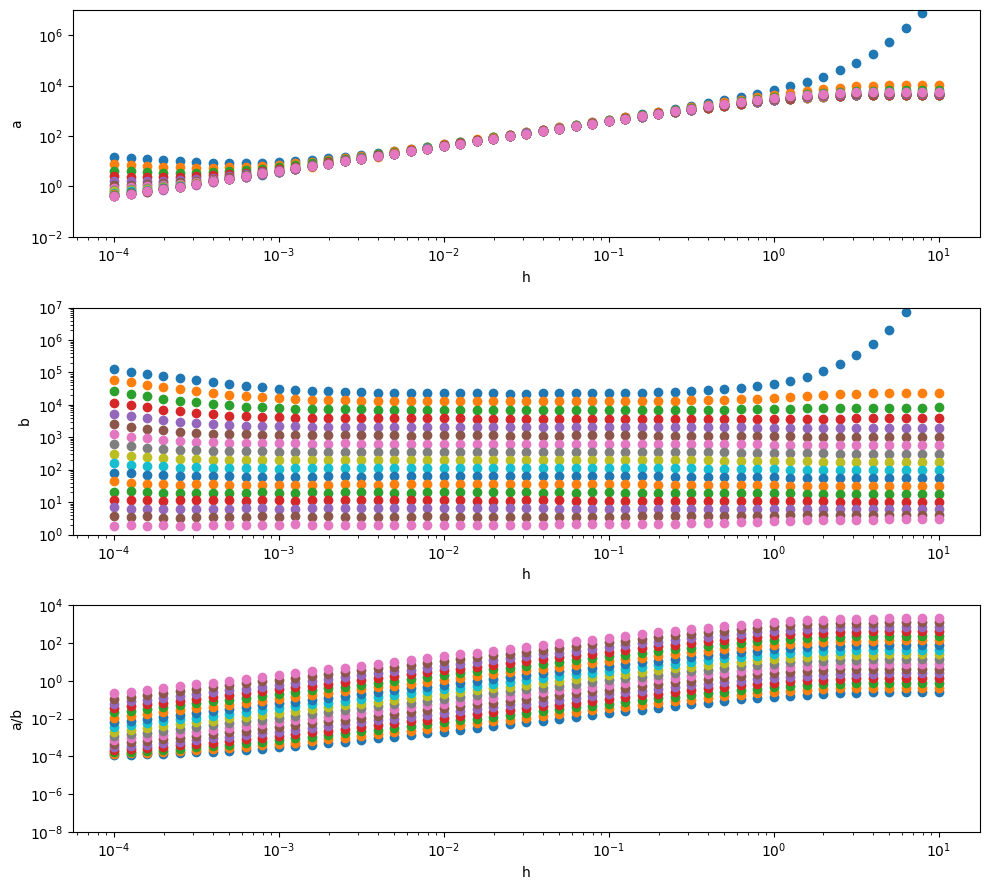

In [13]:
# plot beta parameters for different windows and lambdas from dataframe
fig, axes = plt.subplots(3, 1, figsize=(10, 9))
windows = df["window"].unique()
lambdas = df["lam"].unique()
hs = df["h"].unique()
seeds = df["seed"].unique()
# reverse the order of the windows

window=1
#lam=0.9
#for window in sorted(windows)[::-1]:
for lam in lambdas:
    df_temp = df[(df["window"] == window) & (df["lam"] == lam)]
    axes[0].scatter(df_temp["h"].values, df_temp["a"], label="{} {}".format(window, lam))
    axes[1].scatter(df_temp["h"].values, df_temp["b"], label="{} {}".format(window, lam))
    axes[2].scatter(df_temp["h"].values, df_temp["a"] / df_temp["b"], label="{} {}".format(window, lam))

axes[0].set_xlabel("h")
axes[1].set_xlabel("h")
axes[2].set_xlabel("h")
axes[0].set_ylabel("a")
axes[1].set_ylabel("b")
axes[2].set_ylabel("a/b")

axes[0].set_yscale("log")
axes[1].set_yscale("log")
axes[2].set_yscale("log")

axes[0].set_xscale("log")
axes[1].set_xscale("log")
axes[2].set_xscale("log")

axes[0].set_ylim(1e-2, 1e7)
axes[1].set_ylim(1e0, 1e7)
axes[2].set_ylim(1e-8, 1e4)

#axes[0].legend(loc='upper left')
plt.tight_layout()

Fit the available data with a deep neural network that maps system parameters (h,epsilon) to beta-distribution parameters (a,b)

In [14]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [15]:
import sklearn
from sklearn.preprocessing import MinMaxScaler

def get_data(dataframe, shuffle=1234):
    # x data is a stack of the columns (window, lam, h)
    X = dataframe[["window", "lam", "h"]].values
    # transform into log space
    X[:,0] = np.log10(X[:,0])
    X[:,1] = np.log10(1-X[:,1])
    X[:,2] = np.log10(X[:,2])
    # y data is a stack of the columns (a, b, loc, scale)
    Y = dataframe[["a", "b", "loc", "scale"]].values
    # transform a, b, into log space
    Y[:,0] = np.log10(Y[:,0])
    Y[:,1] = np.log10(Y[:,1])
    print(X.shape, Y.shape)
    # shuffle with random mask
    mask = np.arange(len(X))
    # if shuffle is not False:
    if shuffle is not None:
        np.random.seed(shuffle)
        np.random.shuffle(mask)
    return X[mask], Y[mask], 
get_data(df, shuffle=None)

(5202, 3) (5202, 4)


(array([[ 0. ,  0. , -4. ],
        [ 0. ,  0. , -3.9],
        [ 0. ,  0. , -3.8],
        ...,
        [-6. , -4. ,  0.7],
        [-6. , -4. ,  0.8],
        [-6. , -4. ,  0.9]]),
 array([[ 1.17050535e+00,  5.09144856e+00, -1.00000000e-04,
          1.00020000e+00],
        [ 1.12108882e+00,  5.02370911e+00, -1.00000000e-04,
          1.00020000e+00],
        [ 1.07463307e+00,  4.95523185e+00, -1.00000000e-04,
          1.00020000e+00],
        ...,
        [ 3.67350148e+00,  3.75347586e-01, -1.00000000e-04,
          1.00020000e+00],
        [ 3.67610401e+00,  3.75814863e-01, -1.00000000e-04,
          1.00020000e+00],
        [ 3.67686155e+00,  3.75932646e-01, -1.00000000e-04,
          1.00020000e+00]]))

We follow here the [simple example](https://notebook.community/kit-cel/lecture-examples/mloc/ch3_Deep_Learning/pytorch/function_approximation_with_MLP) using pytorch

Define the model

TODO: In principle we know the $h->0$ and $h->\infty$ solution from the $T->\infty$ solution. Can we make use of this?

(5202, 3) (5202, 4)


100%|██████████| 10000/10000 [01:10<00:00, 141.98it/s]


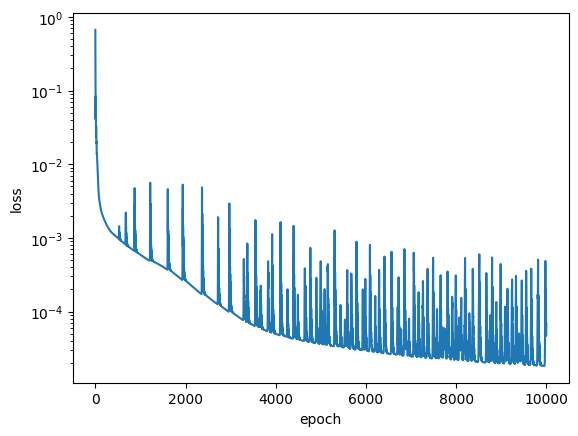

In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(3, 42)
        self.act1 = nn.Tanh()
        self.hidden2 = nn.Linear(42, 42)
        self.act2 = nn.Tanh()
        self.hidden3 = nn.Linear(42, 42)
        self.act3 = nn.Tanh()
        self.output = nn.Linear(42, 4)
        #self.act_output = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.output(x)
        return x
 

def train_model_simple(X_train, Y_train, epochs):
    """
    Trains a simple neural network with one hidden layer with units neurons
    """
    # prepare data
    X_train_tensor = torch.from_numpy(X_train).float()
    Y_train_tensor = torch.from_numpy(Y_train).float()

    # create model
    model = NeuralNetwork()

    # Adam and MSE Loss
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.MSELoss(reduction='mean')
    
    # main loop    
    history_loss = []
    for epoch in tqdm(range(epochs)):
        yhat = model(X_train_tensor)
        loss = loss_fn(yhat, Y_train_tensor)
        history_loss.append(loss.item())
        # compute gradients
        loss.backward() 
        # carry out one optimization step with Adam
        optimizer.step()   
        # reset gradients to zero
        optimizer.zero_grad()

    return model, history_loss

# rescale data (can use the same scaler multiple times using fit_transform function)
X_scaler = MinMaxScaler(feature_range=(-1, 1))
Y_scaler = MinMaxScaler(feature_range=(-1, 1))
X, Y = get_data(df)
X_scaled = X_scaler.fit_transform(X)
Y_scaled = Y_scaler.fit_transform(Y)

# train model
model, loss = train_model_simple(X_scaled, Y_scaled, 10000)
plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.show()


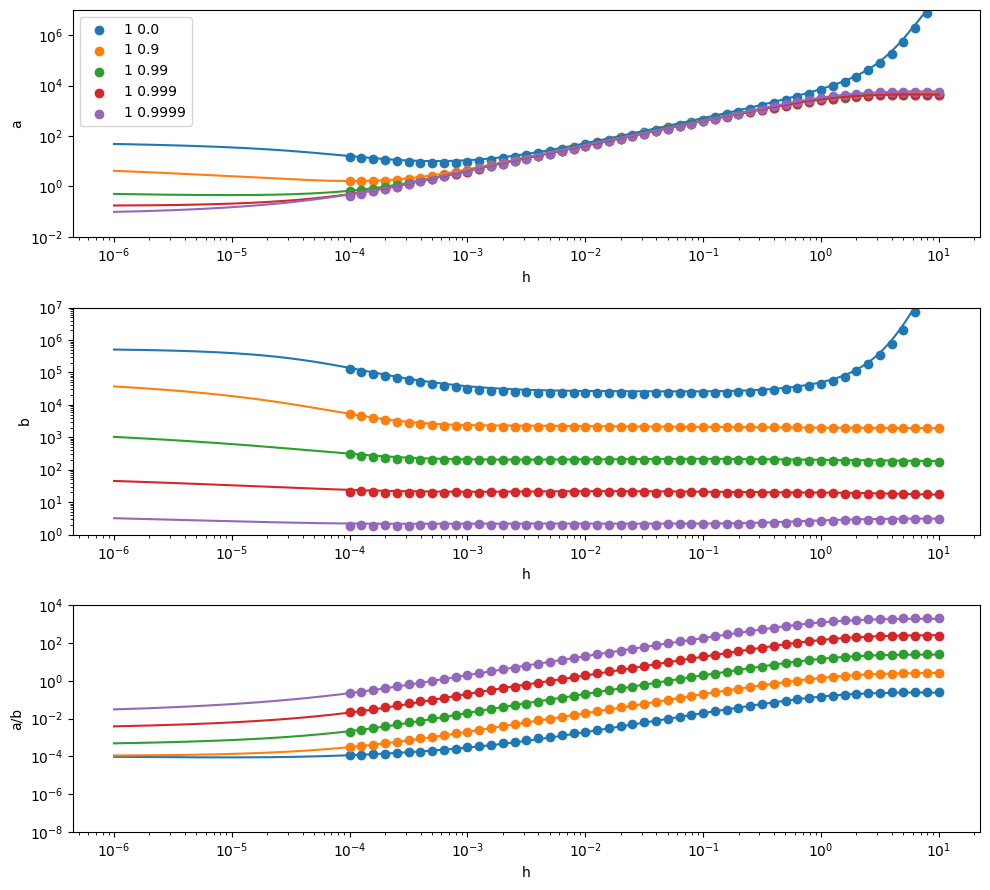

In [38]:
import itertools
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 1, figsize=(10, 9))

# mesh grid for contour plot
log10hs = np.linspace(-6, 1, 200)

windows = df["window"].unique()
lambdas = np.sort(df["lam"].unique())
hs = df["h"].unique()
seeds = df["seed"].unique()
# reverse the order of the windows

window=1
#lam=0.9
#for window in sorted(windows)[::-1]:
for lam in lambdas[::4]:
    df_temp = df[(df["window"] == window) & (df["lam"] == lam)]
    X_model = np.dstack([np.log10(window)*np.ones_like(log10hs), np.log10(1-lam)*np.ones_like(log10hs), log10hs]).reshape(-1, 3)
    X_model_scaled = X_scaler.transform(X_model)
    Y_model_scaled = model(torch.from_numpy(X_model_scaled).float()).detach().numpy()
    Y_model = Y_scaler.inverse_transform(Y_model_scaled)

    a_model = 10**Y_model[:, 0]
    b_model = 10**Y_model[:, 1]

    ref = axes[0].scatter(df_temp["h"].values, df_temp["a"], label="{} {}".format(window, lam))
    axes[0].plot(10**log10hs, a_model, color=ref.get_facecolor()[0])
    axes[1].scatter(df_temp["h"].values, df_temp["b"], label="{} {}".format(window, lam))
    axes[1].plot(10**log10hs, b_model, color=ref.get_facecolor()[0])
    axes[2].scatter(df_temp["h"].values, df_temp["a"] / df_temp["b"], label="{} {}".format(window, lam))
    axes[2].plot(10**log10hs, a_model/b_model, color=ref.get_facecolor()[0])

axes[0].set_xlabel("h")
axes[1].set_xlabel("h")
axes[2].set_xlabel("h")
axes[0].set_ylabel("a")
axes[1].set_ylabel("b")
axes[2].set_ylabel("a/b")

axes[0].set_yscale("log")
axes[1].set_yscale("log")
axes[2].set_yscale("log")

axes[0].set_xscale("log")
axes[1].set_xscale("log")
axes[2].set_xscale("log")

axes[0].set_ylim(1e-2, 1e7)
axes[1].set_ylim(1e0, 1e7)
axes[2].set_ylim(1e-8, 1e4)

axes[0].legend(loc='upper left')
plt.tight_layout()

### Convolution of beta distribution with Guassian 

In [17]:
delta = 1/N
support = np.arange(0, 1+4*sigma, delta)
support = np.concatenate((-support[::-1], support[1:]))

def ml_pmf(window, lam, h, verbose=False):
    # distribution is given by Beta-distribution specified by a and b
    X = np.log10(np.array([window, 1-lam, h]))
    X_scaled = X_scaler.transform(X.reshape(-1,1).T)
    Y_scaled = model(torch.from_numpy(X_scaled).float()).detach().numpy()
    log10a, log10b, loc, scale = Y_scaler.inverse_transform(Y_scaled).T.reshape(-1)
    a,b = 10**log10a, 10**log10b
    pmf_beta = stats.beta.pdf(support, a, b, loc=loc, scale=scale)*delta
    # check for special cases with vanishing pmf
    if np.sum(pmf_beta) < 0.5:
        print(f'ERROR: (a,b)=({a},{b}) vanishing beta distribution with sum(pmf)={np.sum(pmf_beta)}')
    # check for special cases that result in delta distribution (find any pmf_beta to be infinity)
    if np.any(pmf_beta==np.inf):
        if verbose:
            print(f'WARNING: (a,b)=({a},{b}) infinity encountered in beta distribution, converted to pmf with single probable state')
        mask = pmf_beta==np.inf
        pmf_beta[mask] = 1
        pmf_beta[~mask] = 0
        if np.sum(pmf_beta) != 1:
            print("ERROR: pmf not normalized to 1")
    pmf_norm = stats.norm.pdf(support, 0, sigma)*delta
    # convolution with a Gaussian distribution at every point of the support
    return np.convolve(pmf_beta, pmf_norm, mode="same")

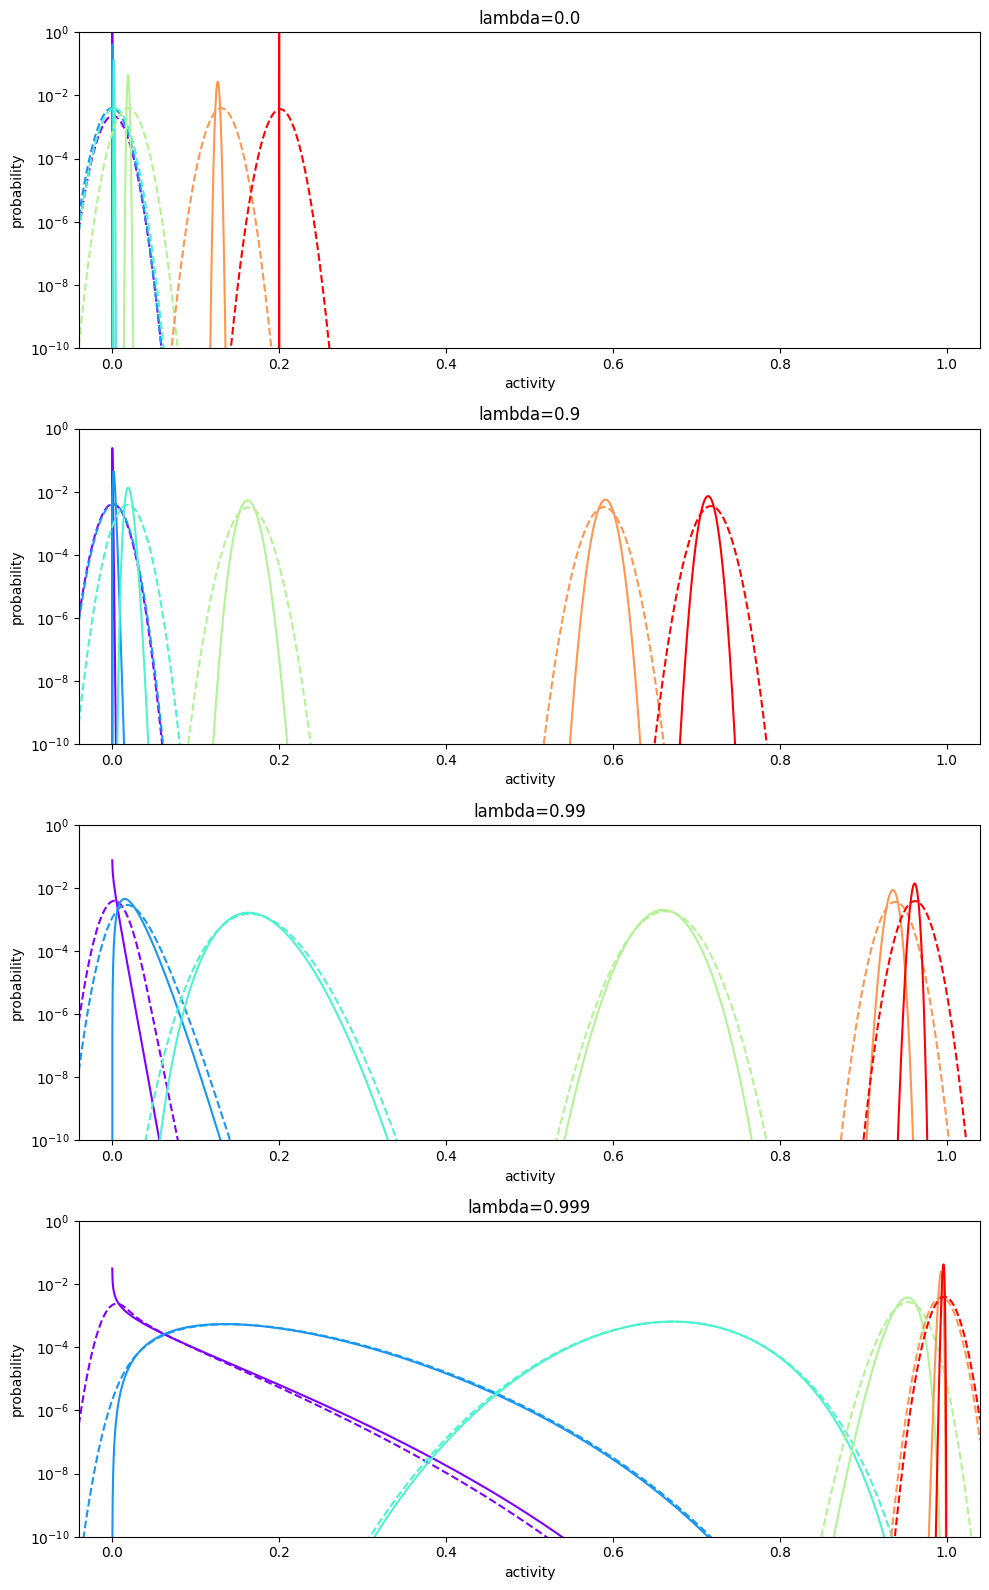

In [47]:
from matplotlib.pyplot import cm

# plot resulting distributions for different values of h and epsilon
list_lam = [0.0, 0.9, 0.99, 0.999]
fig, axes = plt.subplots(len(list_lam),1, figsize=(10, 4*len(list_lam)))

list_hs = 10**np.linspace(-4, 1, 6)
for (i,lam) in enumerate(list_lam):
    color = iter(cm.rainbow(np.linspace(0, 1, len(list_hs))))
    for h in list_hs:
        a,b,loc,scale = df.loc[ (df['window']==1) & (df['lam']==lam) & (df['h']==h) ].values[0][4:]
        c = next(color)
        pmf_beta = stats.beta.pdf(support, a, b, loc=loc, scale=scale)*delta
        axes[i].plot(support, pmf_beta, color=c)
        # from ML dashed
        pmf_ml = ml_pmf(window, lam, h)
        axes[i].plot(support, pmf_ml, color=c, linestyle='--')
        axes[i].set_xlim(0-4*sigma,1+4*sigma)
        axes[i].set_xlabel("activity")
        axes[i].set_ylabel("probability")
        axes[i].set_title("lambda={}".format(lam))
        axes[i].set_yscale("log")
        axes[i].set_ylim(1e-10, 1e0)
plt.tight_layout()


From the interpolation model we can obtain estimates of the dynamic range and the resolution

Important: Need to be able to specify reference distributions! Else we cannot parse no/full activity for simulations. Reference could come from infinite-T solution plus Gaussian!

0.0
hs_left:  [0.08782189050361577, 0.1882872581479299, 0.29812093946521323, 0.4174179148769301, 0.5481328837359384, 0.6942261248400443, 0.8621326042641732, 1.0623240735175774, 1.3132742777819622, 1.6524927924461332]
hs_right:  [2.039411442663879, 1.569366410945389, 1.2539738829977412, 1.0160948272577337, 0.8239880780668063, 0.661446823127641, 0.5190807017982929, 0.39106682951268806, 0.27388737260771434, 0.16601177194472724]


(-0.04, 1.04)

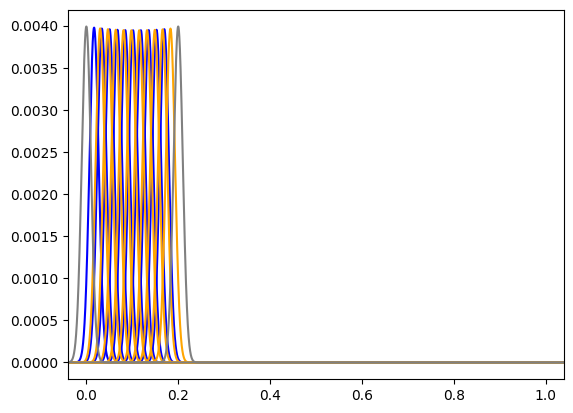

In [102]:
# test discriminable intervals
lam = 0.0
window = 1 
def _pmf(h):
    return ml_pmf(window, lam, h)

# has to be in range of data! (lam=0 there is sth odd with the data fit?)
h_range=[10**-4,10]
# pmf from Gaussians around mean-field solution for h=0 and h->infty
# support defined above!
print(mf_activity(lam, mu, 0))
pmf_ref_left = stats.norm.pdf(support, mf_activity(lam, mu, 0), sigma)*delta
pmf_ref_right = stats.norm.pdf(support, mf_activity(lam, mu, 1e3), sigma)*delta

hs_left = find_discriminable_inputs(_pmf, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="left")
print("hs_left: ", hs_left)
for h in hs_left:
    plt.plot(support, _pmf(h), color="blue")

hs_right = find_discriminable_inputs(_pmf, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right")
print("hs_right: ", hs_right)
for h in hs_right:
    plt.plot(support, _pmf(h), color="orange")

plt.plot(support, pmf_ref_left, color="gray")
plt.plot(support, pmf_ref_right, color="gray")
plt.xlim(0-4*sigma,1+4*sigma)

# plt.legend()

In [103]:
lams = np.sort(df['lam'].unique())

# analysis parameters
drs = np.zeros(len(lams))
nds = np.zeros(len(lams))
mis = np.zeros(len(lams))

# need to exclude the zero here because of logh fit
h_range=[10**-4, 10]

for i, lam in tqdm(enumerate(lams), total=len(lams)):
    print(i,lam)
    # distribution is given by Beta-distribution specified by a and b
    def pmf_o_given_h(h):
        return ml_pmf(window, lam, h)
    pmf_ref_left = stats.norm.pdf(support, a_inf(lam, mu, 0), sigma)*delta
    pmf_ref_right = stats.norm.pdf(support, a_inf(lam, mu, 1e3), sigma)*delta
    hs_left = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon)
    hs_right = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right")
    # print(hs_left,hs_right)
    if len(hs_left) > 0 and len(hs_right) > 0:
        drs[i] = dynamic_range((hs_left[0], hs_right[0]))
        nds[i] = 0.5 * (len(hs_left) + len(hs_right))
    else:
        drs[i] = 0
        nds[i] = 0


  0%|          | 0/17 [00:00<?, ?it/s]

0 0.0


  6%|▌         | 1/17 [01:47<28:34, 107.16s/it]

[0.08782189050361577, 0.1882872581479299, 0.29812093946521323, 0.4174179148769301, 0.5481328837359384, 0.6942261248400443, 0.8621326042641732, 1.0623240735175774, 1.3132742777819622, 1.6524927924461332] [2.039411442663879, 1.569366410945389, 1.2539738829977412, 1.0160948272577337, 0.8239880780668063, 0.661446823127641, 0.5190807017982929, 0.39106682951268806, 0.27388737260771434, 0.16601177194472724]
1 0.4376586748096509


 12%|█▏        | 2/17 [04:52<38:18, 153.21s/it]

[0.04810945995964555, 0.09981593309479056, 0.1556274165157931, 0.21627876145615993, 0.28205394095431785, 0.35333229102384617, 0.4307957751052453, 0.5155396845534072, 0.6091715307132265, 0.714005286947498, 0.8333702893743644, 0.9722061928452453, 1.1381876544435057, 1.344140652933748, 1.613751329453336, 1.99858193838483] [2.463653930905119, 1.897751678832534, 1.5460204275979998, 1.2936700210233139, 1.0981828109369085, 0.9391404835461002, 0.8052022200251859, 0.6894451327355567, 0.5873608946992713, 0.4958878661325689, 0.4128914999763619, 0.3368897919461449, 0.26688893819143183, 0.20228441367310135, 0.14274225116707595, 0.08794738500274428]
2 0.683772233983162


 18%|█▊        | 3/17 [07:38<37:08, 159.21s/it]

[0.027761542629931243, 0.056366322287554296, 0.0863122731407715, 0.118476255637863, 0.15332665564535347, 0.19115200503563856, 0.23217241843760647, 0.27660942351853945, 0.3247319218052896, 0.3769056125936041, 0.43362414787476666, 0.4955559392348207, 0.56359503673545, 0.6389380753353003, 0.7232041370109589, 0.8186167332917212, 0.928303092586372, 1.05683369116742, 1.211192811530641, 1.4027528663845792, 1.651785907189595, 1.99958679602562, 2.5520148374029734] [2.983364222719952, 2.228573112937697, 1.8032645824845117, 1.5139478532747308, 1.2980339844185191, 1.127536616652921, 0.9876198735296121, 0.8695273897778267, 0.7676877329044591, 0.6783684118152035, 0.5989540076710371, 0.527563285453683, 0.4628118087242751, 0.4036741860562345, 0.3493788754306977, 0.2993533497630651, 0.25317667347302575, 0.21053618260614473, 0.1711949389929444, 0.13493882201708404, 0.10152230144682473, 0.07058242548174362, 0.04147970317636347]
3 0.8221720589961077


 24%|██▎       | 4/17 [11:41<41:38, 192.19s/it]

[0.016188448462705368, 0.03279174139464442, 0.04988711455960768, 0.06796349197955122, 0.08737176506867757, 0.10837250428023737, 0.1311733915632494, 0.1559489616240931, 0.18285633765756273, 0.21204758869165366, 0.24368298804180175, 0.27794686298913684, 0.31506410152660763, 0.35531105234022664, 0.3990450729756556, 0.44671997660865653, 0.49891724129696985, 0.5563902169948588, 0.6201214138828208, 0.6914021009484956, 0.7719733614402344, 0.8642256156991095, 0.9715502711436731, 1.09892498003745, 1.254070263458612, 1.449729163895053, 1.7090518111638378, 2.0805617299387564, 2.6946984850775624] [3.1530638150444132, 2.3104607057306152, 1.856616948426255, 1.5557668903481576, 1.3354839674742804, 1.1642436252629895, 1.0256319200281323, 0.9100872615058251, 0.8115947597224904, 0.7261460966817719, 0.650959730285201, 0.5840374211745475, 0.5239053486103489, 0.4694541491249982, 0.41983882754119317, 0.37440627643918406, 0.3326496060981519, 0.2941719733782309, 0.25866308701705654, 0.22587716927106108, 0.195

 29%|██▉       | 5/17 [16:38<46:00, 230.06s/it]

[0.009236233837845852, 0.019016592798129926, 0.029250546085195915, 0.04006698805163363, 0.051630834147625954, 0.06409226284405714, 0.07758888204492126, 0.09225042267301191, 0.10820206661051252, 0.1255664422184255, 0.14446728554099356, 0.16503029135630232, 0.18738886636753485, 0.2116878608308329, 0.23809183451057248, 0.2667925294767592, 0.29801754337569564, 0.3320458043986688, 0.3692217603851391, 0.40997801291942254, 0.45485769404637016, 0.5045619873229762, 0.559997635673949, 0.6223580443015373, 0.6932513920086693, 0.7748858256872115, 0.8703963065468746, 0.9843930701935544, 1.1240046095328766, 1.3009544444647712, 1.536359272222241, 1.8735732250827248, 2.424009315363966] [2.851863170294852, 2.0953884711557604, 1.6793101028652293, 1.403390253969597, 1.202257004487028, 1.0468160808920568, 0.9217794304821353, 0.8182022635692551, 0.7304534091676202, 0.6547891531754114, 0.5886149452584247, 0.5300662821920996, 0.4777720214511675, 0.4307030335855934, 0.38806793166168585, 0.34925506540906526, 0.

 35%|███▌      | 6/17 [21:29<45:56, 250.57s/it]

[0.005131783148893682, 0.010819721813197668, 0.01710048894484134, 0.02392034890017331, 0.03130703841674566, 0.039317632634348613, 0.04802215571672061, 0.05749890318135438, 0.06783332723376634, 0.07911779174959455, 0.09145106335758534, 0.10493975160053787, 0.11969885837409587, 0.13585176673997146, 0.15353512572231412, 0.17289925036132683, 0.19411507849240525, 0.2173780031346804, 0.24291869286266793, 0.2710118857861836, 0.3019970452548716, 0.3362915051597776, 0.3744259960685298, 0.41708326986277433, 0.4651563992787383, 0.519839706834687, 0.5827639291751815, 0.6562198140193741, 0.7435432843666734, 0.8497989261645227, 0.9831003105156428, 1.157479223998623, 1.3998766751539413, 1.771304662097348] [2.407941836548442, 1.747197062780099, 1.3850482533811008, 1.147178515631489, 0.9754101163267761, 0.8437707867305596, 0.7386529967816478, 0.6521443493295308, 0.5792988841515722, 0.516847480112574, 0.46253987067745717, 0.4147712376340997, 0.37236601417894294, 0.3344437378165756, 0.30033059988834543, 

 41%|████      | 7/17 [26:38<44:56, 269.62s/it]

[0.0028670767955120365, 0.006150567788839697, 0.01007331969868162, 0.014580154752049806, 0.019636964899861522, 0.025243026593320804, 0.03142342549356893, 0.038222366875739974, 0.04569894136757277, 0.05392541948342707, 0.06298612435132059, 0.07297817300638955, 0.08401188345334014, 0.09621181258460054, 0.10971891785836893, 0.12469291038645278, 0.14131605117072174, 0.15979854371095353, 0.18038770042620192, 0.20337650778848332, 0.22912280306618954, 0.25807171024217457, 0.29079113807048557, 0.32802040292732276, 0.37075178536224074, 0.42035037843710477, 0.47875808862608377, 0.5488395451826382, 0.6350217933541685, 0.7445629263942148, 0.8903566870003616, 1.0980569670789493, 1.4286672302953864] [1.9779816334316929, 1.3816559701674003, 1.070302082465272, 0.8715701684595782, 0.7307813032062899, 0.6243589060831017, 0.5402771075262846, 0.47168962303549655, 0.4143910094927884, 0.3656452227942995, 0.32359065761084677, 0.2869116493768501, 0.2546487877209456, 0.2260843085054532, 0.20066756853348278, 0.

 47%|████▋     | 8/17 [31:35<41:47, 278.59s/it]

[0.0016720377667449723, 0.0036460169357445168, 0.006204137345408393, 0.009362803572792545, 0.013092795666094644, 0.01737454302971144, 0.0222136346002707, 0.027640430646911306, 0.03370663312354588, 0.04048354977745103, 0.048061123085031514, 0.05654892068326777, 0.0660779647961363, 0.07680296466017864, 0.08890737134357708, 0.1026079387590768, 0.11816173322497903, 0.13587866473325425, 0.156135575138209, 0.17940267751240294, 0.20628070930542486, 0.23756134573831353, 0.27432615951352574, 0.3181123725579764, 0.37120161589336037, 0.43717207269590586, 0.5220054325731431, 0.636615865843268, 0.803523119273376, 1.0791798430665502] [1.5700374859067807, 1.039812354869119, 0.7813124132780561, 0.6219690988130268, 0.5114446318322375, 0.42910540594464963, 0.36479154350073084, 0.3128740837702191, 0.2699577900843212, 0.23386329903146058, 0.20311510221369602, 0.1766705162342973, 0.1537623169488725, 0.1338066081316727, 0.11634579513896082, 0.10101078417750764, 0.0874979598080519, 0.07555568553089691, 0.064

 53%|█████▎    | 9/17 [35:49<36:05, 270.75s/it]

[0.0010298798290828129, 0.0023221235590694237, 0.004124541617310638, 0.006510529975415851, 0.009484806069691019, 0.013039147718591217, 0.01718431713228475, 0.0219591690580655, 0.02743144274205665, 0.033697676563887245, 0.040885137642132814, 0.04915514735544486, 0.0587100114177297, 0.0698015554165082, 0.08274353439814877, 0.09792971488139143, 0.11586056875516636, 0.13718405249691576, 0.16276620411905687, 0.1938114391358911, 0.23208289659719036, 0.28033123827019674, 0.343188824855949, 0.4292612048070385, 0.5568703569868863, 0.7742769509908479] [1.182367600123871, 0.7411770062039524, 0.5389085479886256, 0.4176600286605527, 0.33494057943468114, 0.2741099935172082, 0.22720606149163902, 0.18988743503320077, 0.15955123814013716, 0.13451568785233026, 0.11362453837442721, 0.09604155845579403, 0.08113839938944659, 0.06842905330547384, 0.0575301715811756, 0.048135962943998, 0.04000083237574491, 0.032927693022671047, 0.02675922702637541, 0.02137209772798583, 0.016673081268047684, 0.012597786706181

 59%|█████▉    | 10/17 [38:43<28:07, 241.02s/it]

[0.0006640343848102363, 0.0015920798307332723, 0.002975231295157193, 0.004920342111611011, 0.007471282916916598, 0.010649850964785747, 0.014495251990708797, 0.019082641351077158, 0.02453006684657625, 0.031005296270062314, 0.038735955880870684, 0.048025206113584865, 0.059276426292540915, 0.0730287268440404, 0.09001435253850458, 0.11125229994604899, 0.1382189701833974, 0.1731918453132335, 0.21999651552260266, 0.2858660784921883, 0.3869041452803025, 0.5695384393983967] [0.838469828850607, 0.49987319400685526, 0.35098168733716995, 0.2632837478858877, 0.20428379319882878, 0.16160167926717484, 0.12935738260990884, 0.10431478119544263, 0.08449101243455485, 0.0685734534716161, 0.055643187620727445, 0.04503417704364365, 0.036252980973699035, 0.02892952259037676, 0.02278558400073376, 0.01761311816068366, 0.013260192934965184, 0.009622204336064897, 0.006635964755070077, 0.004270319398345108, 0.0025018205793984746, 0.0012707624115828368]
10 0.9968377223398316


 65%|██████▍   | 11/17 [42:04<22:52, 228.68s/it]

[0.0004420118248437689, 0.0011612993772046987, 0.002304330181309903, 0.004002538656679472, 0.0063422920312247956, 0.009393150438231723, 0.013253363272634183, 0.018080009877865254, 0.02411110942082988, 0.0316931957745802, 0.041325105839408065, 0.05373012670777285, 0.06997939288839307, 0.091718857570442, 0.12164270421060151, 0.16464174355801175, 0.23117795384948858, 0.350452212713069] [0.5624417625578007, 0.31961133183004037, 0.21525367982894422, 0.15473084650597685, 0.11488842246849496, 0.0868757112949787, 0.06639272118115964, 0.05101169381483704, 0.039226755540355956, 0.030049252570901276, 0.02280796424990795, 0.017038623239563937, 0.012419128509532926, 0.0087292707613129, 0.005825404342878139, 0.003617905990403847, 0.002037702642337959, 0.000990216677489373]
11 0.9982217205899611


 71%|███████   | 12/17 [44:32<17:00, 204.17s/it]

[0.0003011731538056324, 0.0008918539995090253, 0.0018971793793777778, 0.003477066392408014, 0.005774326273334015, 0.008939627955046487, 0.013191929929464148, 0.018878216294624474, 0.02654641660227314, 0.03706853375484598, 0.05187528224458537, 0.07345548106868348, 0.10659806068302771, 0.16236045152487807, 0.27696237404942486] [0.36019504977047384, 0.1935901570877879, 0.12340800301698826, 0.08386763502456476, 0.058805034952125385, 0.04188972008176377, 0.030006373193989053, 0.021417498786975603, 0.01508311482838419, 0.010354936770328789, 0.006822657918562991, 0.004227449701611601, 0.0024007889292318287, 0.001203119538990949, 0.00047910012552119645]
12 0.999


 76%|███████▋  | 13/17 [46:26<11:46, 176.68s/it]

[0.00021124344892151613, 0.0007191547546412369, 0.0016549906808907126, 0.0032254594395023017, 0.005669921305402929, 0.00930416008746012, 0.014636586983202323, 0.022548796434864495, 0.03464688298466957, 0.05412017561369548, 0.08838575892471444, 0.1611318088021522] [0.22158226008193385, 0.11046684373148417, 0.06550078514364394, 0.04136554412539276, 0.026810479047805345, 0.01745872023588636, 0.011218528317062987, 0.006974322684212986, 0.004094216677624765, 0.002201250483657039, 0.0010355659028685644, 0.00037615887102995826]
13 0.9994376586748096


 82%|████████▏ | 14/17 [48:09<07:43, 154.43s/it]

[0.00014942483457194839, 0.0005972612089245787, 0.0015094981181423331, 0.0031842898331975317, 0.006064015250463615, 0.010876476450202396, 0.019021341012165214, 0.03356832167052527, 0.06288590886774012] [0.13067359655250935, 0.05893076918912418, 0.031746749331673, 0.01803550678895454, 0.01030250919357407, 0.0057201818191408215, 0.002980579158202917, 0.0013950464379717854, 0.000538013782273685]
14 0.9996837722339832


 88%|████████▊ | 15/17 [49:25<04:22, 131.00s/it]

[0.00010692507010834332, 0.0005088642762272674, 0.001445909151141547, 0.0034142524049188597, 0.007370384587211615, 0.015399762924236882, 0.03334358506102941] [0.0731529962875417, 0.029019567136986085, 0.013578272924504975, 0.006488671764614695, 0.0029727399640475712, 0.001231096539873066, 0.0004114510515394027]
15 0.9998221720589962


 94%|█████████▍| 16/17 [49:53<01:39, 99.78s/it] 

[] [0.03828201079539302, 0.012773761126847886, 0.0047798965437541325, 0.0017237902636531687, 0.0005377028225053987, 0.00010676530536933342]
16 0.9999


100%|██████████| 17/17 [50:14<00:00, 177.33s/it]

[] [0.018444342821411046, 0.004751722841422779, 0.0012705997896455194, 0.00028973326268950554]


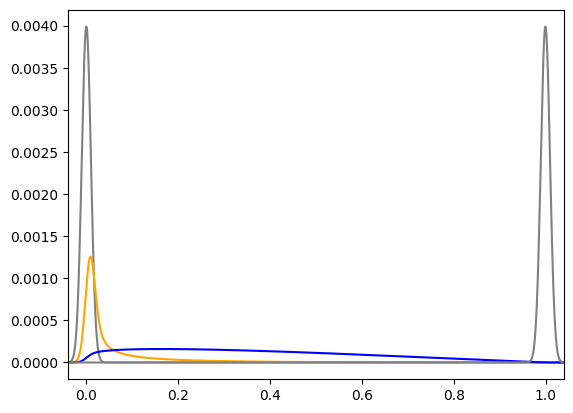

0.2 0.1536025696271382
0.2 0.1871408224530253
0.2 0.017402184140233132
hs from left
possible solution:  0.00013563595809900502 0.0002831309387052992accepted
possible solution:  0.0006763775945326748 0.002366444769393917accepted
possible solution:  0.0024554949818223694 0.01701640001869902accepted
possible solution:  0.008597207639515 0.09030217915144469accepted
possible solution:  0.036879810698064 0.28716409726002323hs from right
possible solution:  0.020185106119344362 7.06469856635258e-05accepted
possible solution:  0.005447273490132051 0.0011327388299816072accepted
possible solution:  0.0015541808118866851 0.011835023903449012accepted
possible solution:  0.00040427469905738 0.07707150628081538accepted
possible solution:  5.788792649239474e-05 0.2706401820925786[0.00013563595809900502, 0.0006763775945326748, 0.0024554949818223694, 0.008597207639515]


In [57]:
# check large lambda in more detail why there is no discriminable points when coming from left
lam = 0.9999
window=1
def pmf_o_given_h(h):
    return ml_pmf(window, lam, h)
h_range=[10**-6, 10]
pmf_ref_left = stats.norm.pdf(support, a_inf(lam, mu, 0), sigma)*delta
pmf_ref_right = stats.norm.pdf(support, a_inf(lam, mu, 1e3), sigma)*delta
plt.plot(support, pmf_ref_left, color="gray")
plt.plot(support, pmf_o_given_h(h_range[0]), color="orange")
plt.plot(support, pmf_o_given_h(0.00028973326268950554), color="blue")
plt.plot(support, pmf_ref_right, color="gray")
plt.xlim(0-4*sigma,1+4*sigma)
plt.show()

print(epsilon, calc_overlap(pmf_ref_left, pmf_o_given_h(h_range[0])))
print(epsilon, calc_overlap(pmf_o_given_h(0.0012705997896455194), pmf_o_given_h(0.00028973326268950554)))
print(epsilon, calc_overlap(pmf_ref_left, pmf_o_given_h(0.00028973326268950554)))
print("hs from left")
hs_left = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_o_given_h(h_range[0]), pmf_ref_right], epsilon, start="left", verbose=True)
print("hs from right")
hs_right = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_o_given_h(h_range[0]), pmf_ref_right], epsilon, start="right", verbose=True)
print(hs_left)

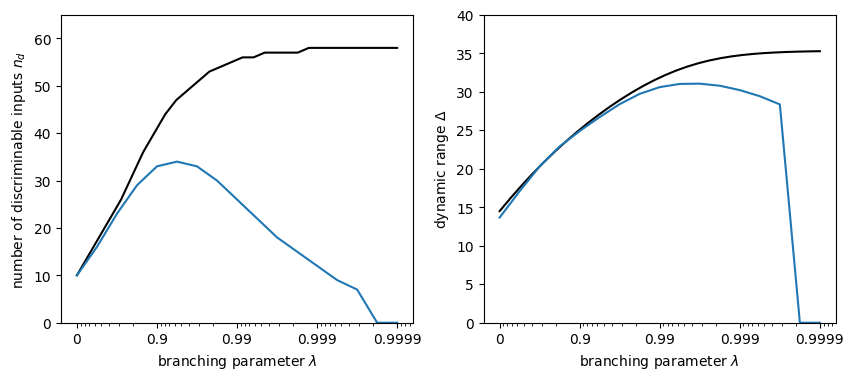

In [104]:
# plot the number of discriminable inputs for different values of epsilon and T in a main plot with an inset
markers = ["o", "s", "^", "P", "d"]
legends = ["$1$ ms", "$10$ ms", "$10^2$ ms", "$10^3$ ms", "$10^4$ ms"]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(1 - lams_mf, nds_inf, label="inf", color="black")
ax[0].plot(1 - lams, nds)
ax[0].set_xlabel("branching parameter $\lambda$")
ax[0].set_ylim(0, 65)
ax[0].set_ylabel("number of discriminable inputs $n_d$")
ax[0].set_xscale("log")
ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[0].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[0].invert_xaxis()
ax[1].plot(1 - lams_mf, drs_inf, label="inf", color="black")
ax[1].plot(1 - lams, drs)
ax[1].set_xlabel("branching parameter $\lambda$")
ax[1].set_ylim(0, 40)
ax[1].set_ylabel("dynamic range $\Delta$")
ax[1].set_xscale("log")
ax[1].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[1].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[1].invert_xaxis()

## TODO:
- Develop an approximation to the finite-time solution as a correction to the infinite T limit?
- Fit this?
- Or take absolute maximum? -> as inset?
- Only Fig n_d and DR ... Lets try to replot with development of maxima as inset
